### Composite AGN Cutout Query Creator
This notebook will create `SQL` query requests for a series of cutout images of a specific single quasar to create training data for the transfer-learning phase on real data for `DualFinder`

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import glob
import scipy
import csv
import pandas as pd
import matplotlib.image as mpimg
from astropy.table import Table
from tqdm.notebook import tqdm,trange
import requests
import time
import tarfile
from schwimmbad import MultiPool
import multiprocess as mp
from astropy.io import fits
import matplotlib as mpl
import os
from os.path import exists
import shutil
import requests
from offset_AGN_dataset_creator import DatasetCreator
%load_ext autoreload
%autoreload 2


In [2]:
print(os.getcwd())
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_R/")
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_G/")
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_Z/")
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_Y/")

/Users/moskowitzi/Library/CloudStorage/Dropbox/First_Year_at_Yale/Summer_2024/DRAGON_CNN


In [3]:
def imgdwnldr_gen(args):
    
    df,num_start,num_stop,fltr = args
    
    t = Table()
    t["rerun"] = ["pdr3_wide"]*len(df[num_start:num_stop])
    t["filter"] = [fltr]*len(df[num_start:num_stop])
    #t["tract"] = df["tract"][num_start:num_stop]
    t["ra"] = df["ra"][num_start:num_stop]
    t["dec"] = df["dec"][num_start:num_stop]
    t["type"] = ["coadd"]*len(df[num_start:num_stop])
    t["sh"] = ["16asec"]*len(df[num_start:num_stop])
    t["sw"] = ["16asec"]*len(df[num_start:num_stop])
    t["name"] = df["name"][num_start:num_stop]
                  
    return t

In [4]:
def table_writer(args):
    
    table, i, filepath_prefix, overwrite, tableformat, comment= args
    #os.chdir(filepath_prefix)
    #print("CURRENT WORKING DIRECTORY: " + str(os.getcwd()))
    table.write(filepath_prefix + "download_sql" + ".txt",
                overwrite=overwrite,format=tableformat,
                comment=comment)
    #os.chdir("/Users/moskowitzi/Library/CloudStorage/Dropbox/First_Year_at_Yale/Summer_2022/Quasar_Research")
#args = (test2DF, 0, 35, "HSC-R")
#secondTestTable = imgdwnldr_gen(args)
#filepath_prefix = 'input_second_test_HSC_new'
def write_dwnldr_files(df,step,filepath_prefix = None,write=True,
                      overwrite=True, fltr = None):   
                  
    len_df = len(df)
    iters = int(len_df/step)
    #print(len_df)
    lwr_ends = range(0,len_df,step)
    upr_ends = range(step,len_df+step,step)
    fltrs = [fltr]*(iters+1)
    dfs = [df]*(iters+1)
    
    args_imgdwnldr_gen = list(zip(dfs,lwr_ends,upr_ends,fltrs))
    #args_imgdwnldr_gen = (dfs,lwr_ends,upr_ends,fltrs)
    #imgdwnldr_gen(args_imgdwnldr_gen)
    with mp.Pool() as pool:
        tables = list(tqdm(pool.imap(imgdwnldr_gen,args_imgdwnldr_gen), total = iters+1))
    
    if write is True:
        paths = [filepath_prefix]*(iters+1)
        overwrites = [overwrite]*(iters+1)
        tableformats = ['ascii.commented_header']*(iters+1)
        comments = ["#?"]*(iters+1)
        i_s = np.arange(iters+1)
    
        args_table_writer = list(zip(tables,i_s,paths,overwrites,tableformats,comments))
        #args_table_writer = (tables,i_s,paths,overwrites,tableformats,comments)
        #table_writer(args_table_writer)
        
        with mp.Pool() as pool:
            exit_codes = list(tqdm(pool.imap(table_writer,args_table_writer), total = iters+1))
        print("got here after table writer")
        
    else:
        for table in tables:
            print(table)
    return tables
def write_rotation_test_coordinates(quasarName, separation, raStart, decStart, fltr):
    count = 0
    degree_separation = separation/3600
    raList = []
    decList = []
    quasarNameList = []
    for i in np.arange(0, 2*np.pi, np.pi/18):
        ra = raStart + degree_separation* np.cos(i)
        dec = decStart + degree_separation* np.sin(i)
        raList.append(ra)
        decList.append(dec)
        quasarNameNew = quasarName + "_HSC_" + str(fltr) + "_rotated_" + str(count) + "_degrees"
        print(quasarNameNew)
        quasarNameList.append(quasarNameNew)
        count+=10
    return raList, decList, quasarNameList
#Automatic downloaders for downloading from HSC servers:
def cutout_requester(args):
    
    session, listpath_prefix, write_path_prefix, i = args
    print(f"listpath_prefix: {listpath_prefix}")
    print(f"write_path_prefix: {write_path_prefix}")
    
    files = {
        'list': (listpath_prefix + "download_sql.txt", open(listpath_prefix + "download_sql.txt", 'rb')),
    }
    
    with session.post('https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout', 
                      files=files, auth=('moskowitzi', 'UCiNwD3CHzbprC8G1QM2aUxpQIZdp2cOjyQWOO7J'), stream=True) as response:
        
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = len(i)  # Define chunk size
        
        with open(write_path_prefix + "download.tar", 'wb') as f, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=write_path_prefix + "download.tar") as progress_bar:
            
            for chunk in response.iter_content(chunk_size):
                if chunk:  # Filter out keep-alive new chunks
                    f.write(chunk)
                    progress_bar.update(len(chunk))
def members(tf):
    
    for i, member in enumerate(tf.getmembers()):
        if i == 0:
            l = len(member.path.split("/")[0]) + 1
        
        member.path = member.path[l:]
        yield member
def write_band_download_cutouts(quasarNameList, raList, decList, fltr, filepath, filepath_prefix, separation):
    
    header = ['ra', 'dec', 'name']
   
    #if not (exists(filepath) or exists(filepath_prefix)):
        #os.makedirs(filepath)
        #os.makedirs(filepath_prefix)
    if not exists(filepath):
        os.makedirs(filepath)
    if not exists(filepath_prefix):
        os.makedirs(filepath_prefix)
    with open(filepath + "catalog_" + str(separation) + ".csv", 'w', encoding = 'UTF8') as f: 
        writer = csv.writer(f)
        writer.writerow(header)
        for j in range(len(raList)):
            #print("raList[j]: " + str(raList[j]))
            #print(type(raList[j]))
            combinedData = [raList[j], decList[j], quasarNameList[j]]
            writer.writerow(combinedData)
    #print("got here")
    test_df = pd.read_csv(filepath + "catalog_" + str(separation) + ".csv", delimiter = ',')
    write = True
    overwrite = True
    #print(test_df)
    write_dwnldr_files(test_df, fltr = fltr, step=len(raList), write=write,overwrite=overwrite,
                filepath_prefix = filepath_prefix)
        
#Function to actuall extract all the tarballs
def extractor(args):
    tar_file_prefix, write_path, i = args
    
    with tarfile.open(tar_file_prefix + f"download.tar") as tf:
        tf.extractall(write_path,members=members(tf))

In [5]:
def reducedAmplitudeTestFile(quasarName, percentage, separation, raStart, decStart, fltr, filepath = None):
    quasarName = quasarName
    
    #raStart = 154.60814662744912
    #decStart = 0.34943320872888634
    raList, decList, quasarNameList = write_rotation_test_coordinates(quasarName, separation, raStart, decStart, fltr)
    print("got here")
    header = ['ra', 'dec', 'name']
#args = secondTestTable, filepath_prefix, overwrite, tableformat, comment
#table_writer(args)
    print(len(quasarNameList))
    print(len(raList))
    print(len(decList))
    if not exists(filepath):
        os.makedirs(filepath)
    with open(filepath + "rotation_test_reduced_amplitude_"+str(separation)+".csv", 'w', encoding = 'UTF8') as f: 
        writer = csv.writer(f)
        writer.writerow(header)
        for j in range(len(raList)):
            combinedData = [raList[j], decList[j], quasarNameList[j]]
            writer.writerow(combinedData)
    #print("got here")
    test_df = pd.read_csv(filepath + "rotation_test_reduced_amplitude_"+str(separation)+".csv", delimiter = ',')
    write = True
    overwrite = True
    if not exists(filepath + "downloader_files/downloader_for_" + str((separation)) + "/"):
        os.makedirs(filepath + "downloader_files/downloader_for_" + str((separation)) + "/")
    tables = write_dwnldr_files(test_df,step=len(raList), fltr = fltr, write=write,overwrite=overwrite,
                filepath_prefix= filepath + "downloader_files/downloader_for_" + str((separation)) + "/")
    print(test_df)

In [ ]:
img = fits.getdata("cutout-HSC-G-9226-pdr3_wide-240530-152449.fits")
plt.imshow(img, vmin = np.percentile(img, 1), vmax = np.percentile(img, 99))

In [ ]:
#os.chdir("/vast/palmer/scratch/urry/iam37/")
#All Spring Equitorial Quasars in SDSS and HSC
starttime = time.time()
fits_table_dr16q = 'DR16Q_v4.fits'
hdu1 = fits.open(fits_table_dr16q)
data = hdu1[1].data
min_row_fall_1 = 668635
max_row_fall_1 = 750414
min_row_fall_2 = 1
max_row_fall_2 = 116727
quasarNameList_fall = []
quasarRAList_fall = []
quasarDecList_fall = []
quasarZList_fall = []
"""Fall Equatorial Band"""
for j in range(min_row_fall_1, max_row_fall_2):
    if(data[j].field(2) >= -1.0 and data[j].field(2) <= 7.0 and (data[j].field(6) == "QSO" or data[j].field(7) == "QSO" or data[j].field(6) == data[j].field(7) == "UNK")):
        quasarName = data[j].field(6) + " " + data[j].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        #quasarNameNoSpaceNoPeriod = quasarNameNoSpace.replace(".", "_")
        #quasarNameNoPlus = quasarNameNoSpaceNoPeriod.replace("+", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_fall.append(inputQuasarName)
        quasarRAList_fall.append(data[j].field(1))
        quasarDecList_fall.append(data[j].field(2))
        quasarZList_fall.append(data[j].field(28))
for j in range(min_row_fall_2, max_row_fall_2):
    if(data[j].field(2) >= -1.0 and data[j].field(2) <= 7.0 and (data[j].field(6) == "QSO" or data[j].field(7) == "QSO" or data[j].field(6) == data[j].field(7) == "UNK")):
        quasarName = data[j].field(6) + " " + data[j].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_fall.append(inputQuasarName)
        quasarRAList_fall.append(data[j].field(1))
        quasarDecList_fall.append(data[j].field(2))
        quasarZList_fall.append(data[j].field(28))
quasarNameList_fall = np.asarray(quasarNameList_fall)
#for j in range(len(quasarNameList_fall)):
    #if quasarNameList_fall[j].find("QSO") == -1:
        #print(quasarNameList_fall[j])
        #print(j)
print(len(quasarNameList_fall))
print(len(quasarDecList_fall))
header = ['ra', 'dec', 'Quasar name', 'Z']
#print(len(quasarNameList))
if not exists("HSC_survey_bands/"):
    os.makedirs("HSC_survey_bands/")
with open("HSC_survey_bands/fall_equitorial_quasar_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(quasarNameList_fall)):
        combinedData = [quasarRAList_fall[i], quasarDecList_fall[i], quasarNameList_fall[i], quasarZList_fall[i]]
        writer.writerow(combinedData)
fall_df = pd.read_csv("HSC_survey_bands/fall_equitorial_quasar_list.csv", delimiter=',')
#print(fall_df)
"""Spring Equatorial Band"""
valid_rows1 = data[170000:552181]
print(data[0][0])
print(data[0].field(2))
quasarNameList_spring = []
quasarRAList = []
quasarDecList = []
quasarZList = []
#We know that HSC's field contains RA = 130º at 199012, I will now test smaller RA's to see if they are also contained within the 
#survey field
for i in range(191617, 552181):
    if (data[i].field(2)>= -7.0 and data[i].field(2) <= 1.0 and (data[i].field(6) == "QSO" or data[i].field(7) == "QSO" or data[i].field(6) == data[i].field(7) == "UNK")):
        quasarName = data[i].field(6) + " " + data[i].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_spring.append(inputQuasarName)
        quasarRAList.append(data[i].field(1))
        quasarDecList.append(data[i].field(2))
        quasarZList.append(data[i].field(28))
quasarNameList_spring = np.asarray(quasarNameList_spring)
#for j in range(len(quasarNameList_spring)):
    #if quasarNameList_spring[j].find("QSO") == -1:
        #print(quasarNameList_spring[j])
        #print("Not a QSO Object")
        #print(j)
header = ['ra', 'dec', 'Quasar name']
print(len(quasarNameList_spring))
with open("HSC_survey_bands/spring_equitorial_quasar_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(quasarNameList_spring)):
        combinedData = [quasarRAList[i], quasarDecList[i], quasarNameList_spring[i], quasarZList[i]]
        writer.writerow(combinedData)
spring_df = pd.read_csv("HSC_survey_bands/spring_equitorial_quasar_list.csv", delimiter=',')
#print(spring_df)
#for i in range(0, len(spring_df)):
    #numpyVersion = spring_df.loc[i].to_numpy()
    #print(numpyVersion)
    #if (numpyVersion[1] <=-6.0):
        #print("Something went wrong here")
        #print(spring_df.loc[i])
#display(spring_df.to_string())
"""
with open("spring_equitorial_quasar_list_hsc_download.csv", "w", encoding='UTF8') as p:
    writer = csv.writer(p)
    header = ["#?", "rerun", "filter", "ra", "dec", "sw", "sh", "name"]
    writer.writerow(header)
    for i in range(0, len(quasarNameList)):
        combinedData = [NaN, "pdr3_wide", "HSC-R", quasarRAList[i], quasarDecList[i], "0.01asec", "0.01asec", "spring_equitorial_"+str(i)]
        writer.writerow(combinedData)
"""
#print(quasarNameList)
#print(quasarZList)
#In this section of the download, we are working in the Spring Equitorial survey path, which goes from roughly
#120 degrees to 225 degrees of RA and -7 to 1 degrees of Dec
"""Northern Sky Band"""
min_row_north = 448834
max_row_north = 602111
quasarNameList_north = []
quasarRAList_north = []
quasarDecList_north = []
quasarZList_north = []
for k in range(min_row_north, max_row_north):
    if(data[k].field(2) >= 42.5 and data[k].field(2) <= 44.0 and (data[k].field(6) == "QSO" or data[k].field(7) == "QSO" or data[k].field(6) == data[k].field(7) == "UNK")):
        quasarName = data[k].field(6) + " " + data[k].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_north.append(inputQuasarName)
        quasarRAList_north.append(data[k].field(1))
        quasarDecList_north.append(data[k].field(2))
        quasarZList_north.append(data[k].field(28))
quasarNameList_north = np.asarray(quasarNameList_north)
#for k in range(len(quasarNameList_north)):
    #if quasarNameList_north[k].find("QSO") == -1:
        #print(quasarNameList_north[k])
        #print(k)
print(len(quasarNameList_north))
print("Total number of QSO objects = " + str(len(quasarNameList_fall) + len(quasarNameList_spring) + len(quasarNameList_north)))
with open("HSC_survey_bands/northern_sky_quasar_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(quasarNameList_north)):
        combinedData = [quasarRAList_north[i], quasarDecList_north[i], quasarNameList_north[i], quasarZList_north[i]]
        writer.writerow(combinedData)
northern_df = pd.read_csv("HSC_survey_bands/northern_sky_quasar_list.csv", delimiter=',')
endtime = time.time()
print("--- %s seconds ---" % (endtime - starttime))

In [ ]:
percentages = np.arange(0.1, 1.0, 0.1)
separations = np.arange(0.55, 2.5, 0.05)
angle = np.arange(0.0, 359.0, 1.0)
quasar_name = "QSO_000035.59-003146.1"
ra_start = 0.14833262219804055 + 0.55 * np.cos(0)/3600.0
dec_start = -0.5294901735587073
filepath = "Rotated_AGN_diff_fltrs/HSC_G/"
fltr = 'HSC-G'
for ii, percentage in tqdm(enumerate(percentages)):
    for j, angular_separation in enumerate(separations):
        angular_separation = np.round(angular_separation, 2)
        tables = reducedAmplitudeTestFile(quasar_name, percentage, angular_separation, ra_start, dec_start, fltr, filepath = filepath)


In [ ]:
#This script creates new 16asec x 16asec cutouts of QSO 101825.95+002057.9 to create dual AGN images that are upscaled to the correct size for the rest of the dataset
percentages = np.arange(0.1, 1.0, 0.1)
separations = np.arange(0.55, 2.5, 0.05)
angle = np.arange(0.0, 359.0, 1.0)
quasar_name = "QSO_101825.95+002057.9"
ra_start = 154.60814662744912 + 0.55 * np.cos(0)/3600.0
dec_start = 0.34943320872888634
filepath = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/HSC_G/"
fltr = 'HSC-G'
for ii, percentage in tqdm(enumerate(percentages)):
    for j, angular_separation in enumerate(separations):
        angular_separation = np.round(angular_separation, 2)
        tables = reducedAmplitudeTestFile(quasar_name, percentage, angular_separation, ra_start, dec_start, fltr, filepath = filepath)


In [ ]:
extract = True
        total_files = 3600

        i_s = np.arange(total_files)
        prefix = ["Rotated_AGN_diff_fltrs/" + fltr+"/downloader_files/downloader_for

In [ ]:
"""
import shutil
import requests
with mp.Pool(processes=total_threads) as pool:
            with requests.Session() as session: #just to keep things clearn
                try:
                    sessions = [session]*len(i_s)
                    args_cutout_requester = list(zip(sessions,prefix,write_path,i_s))
                    exit_codes = list(tqdm(pool.imap_unordered(cutout_requester,args_cutout_requester), total = len(i_s)))
                except:
                    continue
"""

In [6]:
def members(tarf):
    
    for i, member in enumerate(tarf.getmembers()):
        if i == 0:
            l = len(member.path.split("/")[0]) + 1
        
        member.path = member.path[l:]
        yield member
        
        
#Function to actuall extract all the tarballs
def extractor(args):
    tar_file_prefix, write_path, i = args
    
    with tarfile.open(tar_file_prefix + "download.tar") as tarf:
        tarf.extractall(write_path,members=members(tarf))

In [7]:
extract = True
for j, angular_separation in tqdm(enumerate(separations)):
    total_files = 1404

    i_s = np.arange(total_files)
    prefix = "Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/downloaded_images"
    dwnldr_txt_filepath = "Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloader_files/downloader_for_" + str(np.round(angular_separation, 2))+"/"
    write_path = "Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/opened_images"

    #if extract is True:
        #with mp.Pool() as p:
            #exit_codes = list(tqdm(p.imap_unordered(cutout_requester,requester_args), total=len(i_s)))
    total_threads = 2
    #url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout/'
    url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout'
    if not exists("Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/"):
        os.makedirs("Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/")
    #with MultiPool(processes=2) as pool:
        #with requests.Session() as session: #just to keep things clearn
            #sessions = [session]*len(i_s)
            #args_cutout_requester = list(zip(sessions,dwnldr_txt_filepath,write_path,i_s))
            #exit_codes = list(tqdm(pool.imap_unordered(cutout_requester,args_cutout_requester), total = len(i_s)))
    with requests.Session() as session:
        args_cutout_requester = (session,dwnldr_txt_filepath,write_path,i_s)
        cutout_requester(args_cutout_requester)
    extractor_args = (write_path,prefix,i_s)
    extractor(extractor_args)
    #with open("Rotated_AGN_diff_fltrs/" + str(fltr)+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/" + "download.tar", 'wb') as out_file:

    #extractor_args = list(zip(prefix,write_path,i_s))
    #with mp.Pool() as p:
        #exit_codes = list(tqdm(p.imap_unordered(extractor,extractor_args), total=len(i_s)))

NameError: name 'separations' is not defined

In [ ]:
extract = True
for j, angular_separation in tqdm(enumerate(separations)):
    total_files = 1404

    i_s = np.arange(total_files)
    prefix = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/downloaded_images"
    dwnldr_txt_filepath = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloader_files/downloader_for_" + str(np.round(angular_separation, 2))+"/"
    write_path = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/opened_images"

    #if extract is True:
        #with mp.Pool() as p:
            #exit_codes = list(tqdm(p.imap_unordered(cutout_requester,requester_args), total=len(i_s)))
    total_threads = 2
    #url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout/'
    url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout'
    if not exists("dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/"):
        os.makedirs("dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/")
    with requests.Session() as session:
        args_cutout_requester = (session,dwnldr_txt_filepath,write_path,i_s)
        cutout_requester(args_cutout_requester)
    extractor_args = (write_path,prefix,i_s)
    extractor(extractor_args)

In [ ]:
bands = ["HSC-G", "HSC-R", "HSC-Z", "HSC-Y", "HSC-I"]
for fltr in tqdm(bands):
    print(fltr)
    total_files = 100000
    north_filepath_prefix = "entire_bands/" + str(fltr) + "/northern_sky/"
    fall_filepath_prefix = "entire_bands/" + str(fltr) + "/fall_equatorial/"
    spring_filepath_prefix = "entire_bands/" + str(fltr) + "/spring_equatorial/"
    i_s = np.arange(total_files)
    
    north_prefix = north_filepath_prefix + "downloaded_images/"
    north_dwnldr_txt_filepath = north_filepath_prefix
    north_write_path = north_filepath_prefix + "downloaded_images/opened_images"
    
    spring_prefix = spring_filepath_prefix + "downloaded_images/"
    spring_dwnldr_txt_filepath = spring_filepath_prefix
    spring_write_path = spring_filepath_prefix + "downloaded_images/opened_images"
    
    fall_prefix = fall_filepath_prefix + "downloaded_images/"
    fall_dwnldr_txt_filepath = fall_filepath_prefix
    fall_write_path = fall_filepath_prefix + "downloaded_images/opened_images"
    
    """if not exists(fall_prefix) and not exists(fall_dwnldr_txt_filepath) and not exists(fall_write_path):
        os.makedirs(fall_prefix)
        os.makedirs(fall_dwnldr_txt_filepath)
        os.makedirs(fall_write_path)
    if not exists(spring_prefix) and not exists(spring_dwnldr_txt_filepath) and not exists(spring_write_path):
        os.makedirs(spring_prefix)
        os.makedirs(spring_dwnldr_txt_filepath)
        os.makedirs(spring_write_path)
    if not exists(north_prefix) and not exists(north_dwnldr_txt_filepath) and not exists(north_write_path):
        os.makedirs(north_prefix)
        os.makedirs(north_dwnldr_txt_filepath)
        os.makedirs(north_write_path)"""
    write_band_download_cutouts(quasarNameList_fall, quasarRAList_fall, quasarDecList_fall, fltr, fall_dwnldr_txt_filepath, fall_filepath_prefix, 0.0)
    write_band_download_cutouts(quasarNameList_spring, quasarRAList, quasarDecList, fltr, spring_dwnldr_txt_filepath, spring_filepath_prefix, 0.0)
    write_band_download_cutouts(quasarNameList_north, quasarRAList_north, quasarDecList_north, fltr, north_dwnldr_txt_filepath, north_filepath_prefix, 0.0)

    total_threads = 2
    url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout/'
    with requests.Session() as session:
        fall_args_cutout_requester = (session,fall_dwnldr_txt_filepath,fall_prefix,i_s)
        spring_args_cutout_requester = (session,spring_dwnldr_txt_filepath,spring_prefix,i_s)
        north_args_cutout_requester = (session,north_dwnldr_txt_filepath,north_prefix,i_s)
        print("Fall cutouts")
        cutout_requester(fall_args_cutout_requester)
        fall_extractor_args = (fall_write_path,fall_prefix,i_s)
        extractor(fall_extractor_args)
        
        print("Spring cutouts")
        cutout_requester(spring_args_cutout_requester)
        spring_extractor_args = (spring_write_path,spring_prefix,i_s)
        extractor(spring_extractor_args)
        
        print("North cutouts")
        cutout_requester(north_args_cutout_requester)
        spring_extractor_args = (north_write_path,north_prefix,i_s)
        extractor(north_extractor_args)
    

In [11]:
#!pwd
dataset_creation_session = DatasetCreator()
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
rotated_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/"
fits_dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
dataset_creation_session.extract_single_galaxies(single_AGN_filepath)
dataset_creation_session.extract_rotated_AGN(rotated_AGN_filepath)
#dataset_creation_session.extract_single_point_sources(
dataset_creation_session.create_convolution(fits_dual_AGN_filepath)

2000it [00:00, 2212.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.69it/s]
10it [00:10,  1.05s/it]


KeyboardInterrupt: 

In [25]:
!pwd

/Users/moskowitzi/Library/CloudStorage/Dropbox/First_Year_at_Yale/Summer_2024/DRAGON_CNN


0it [00:00, ?it/s]

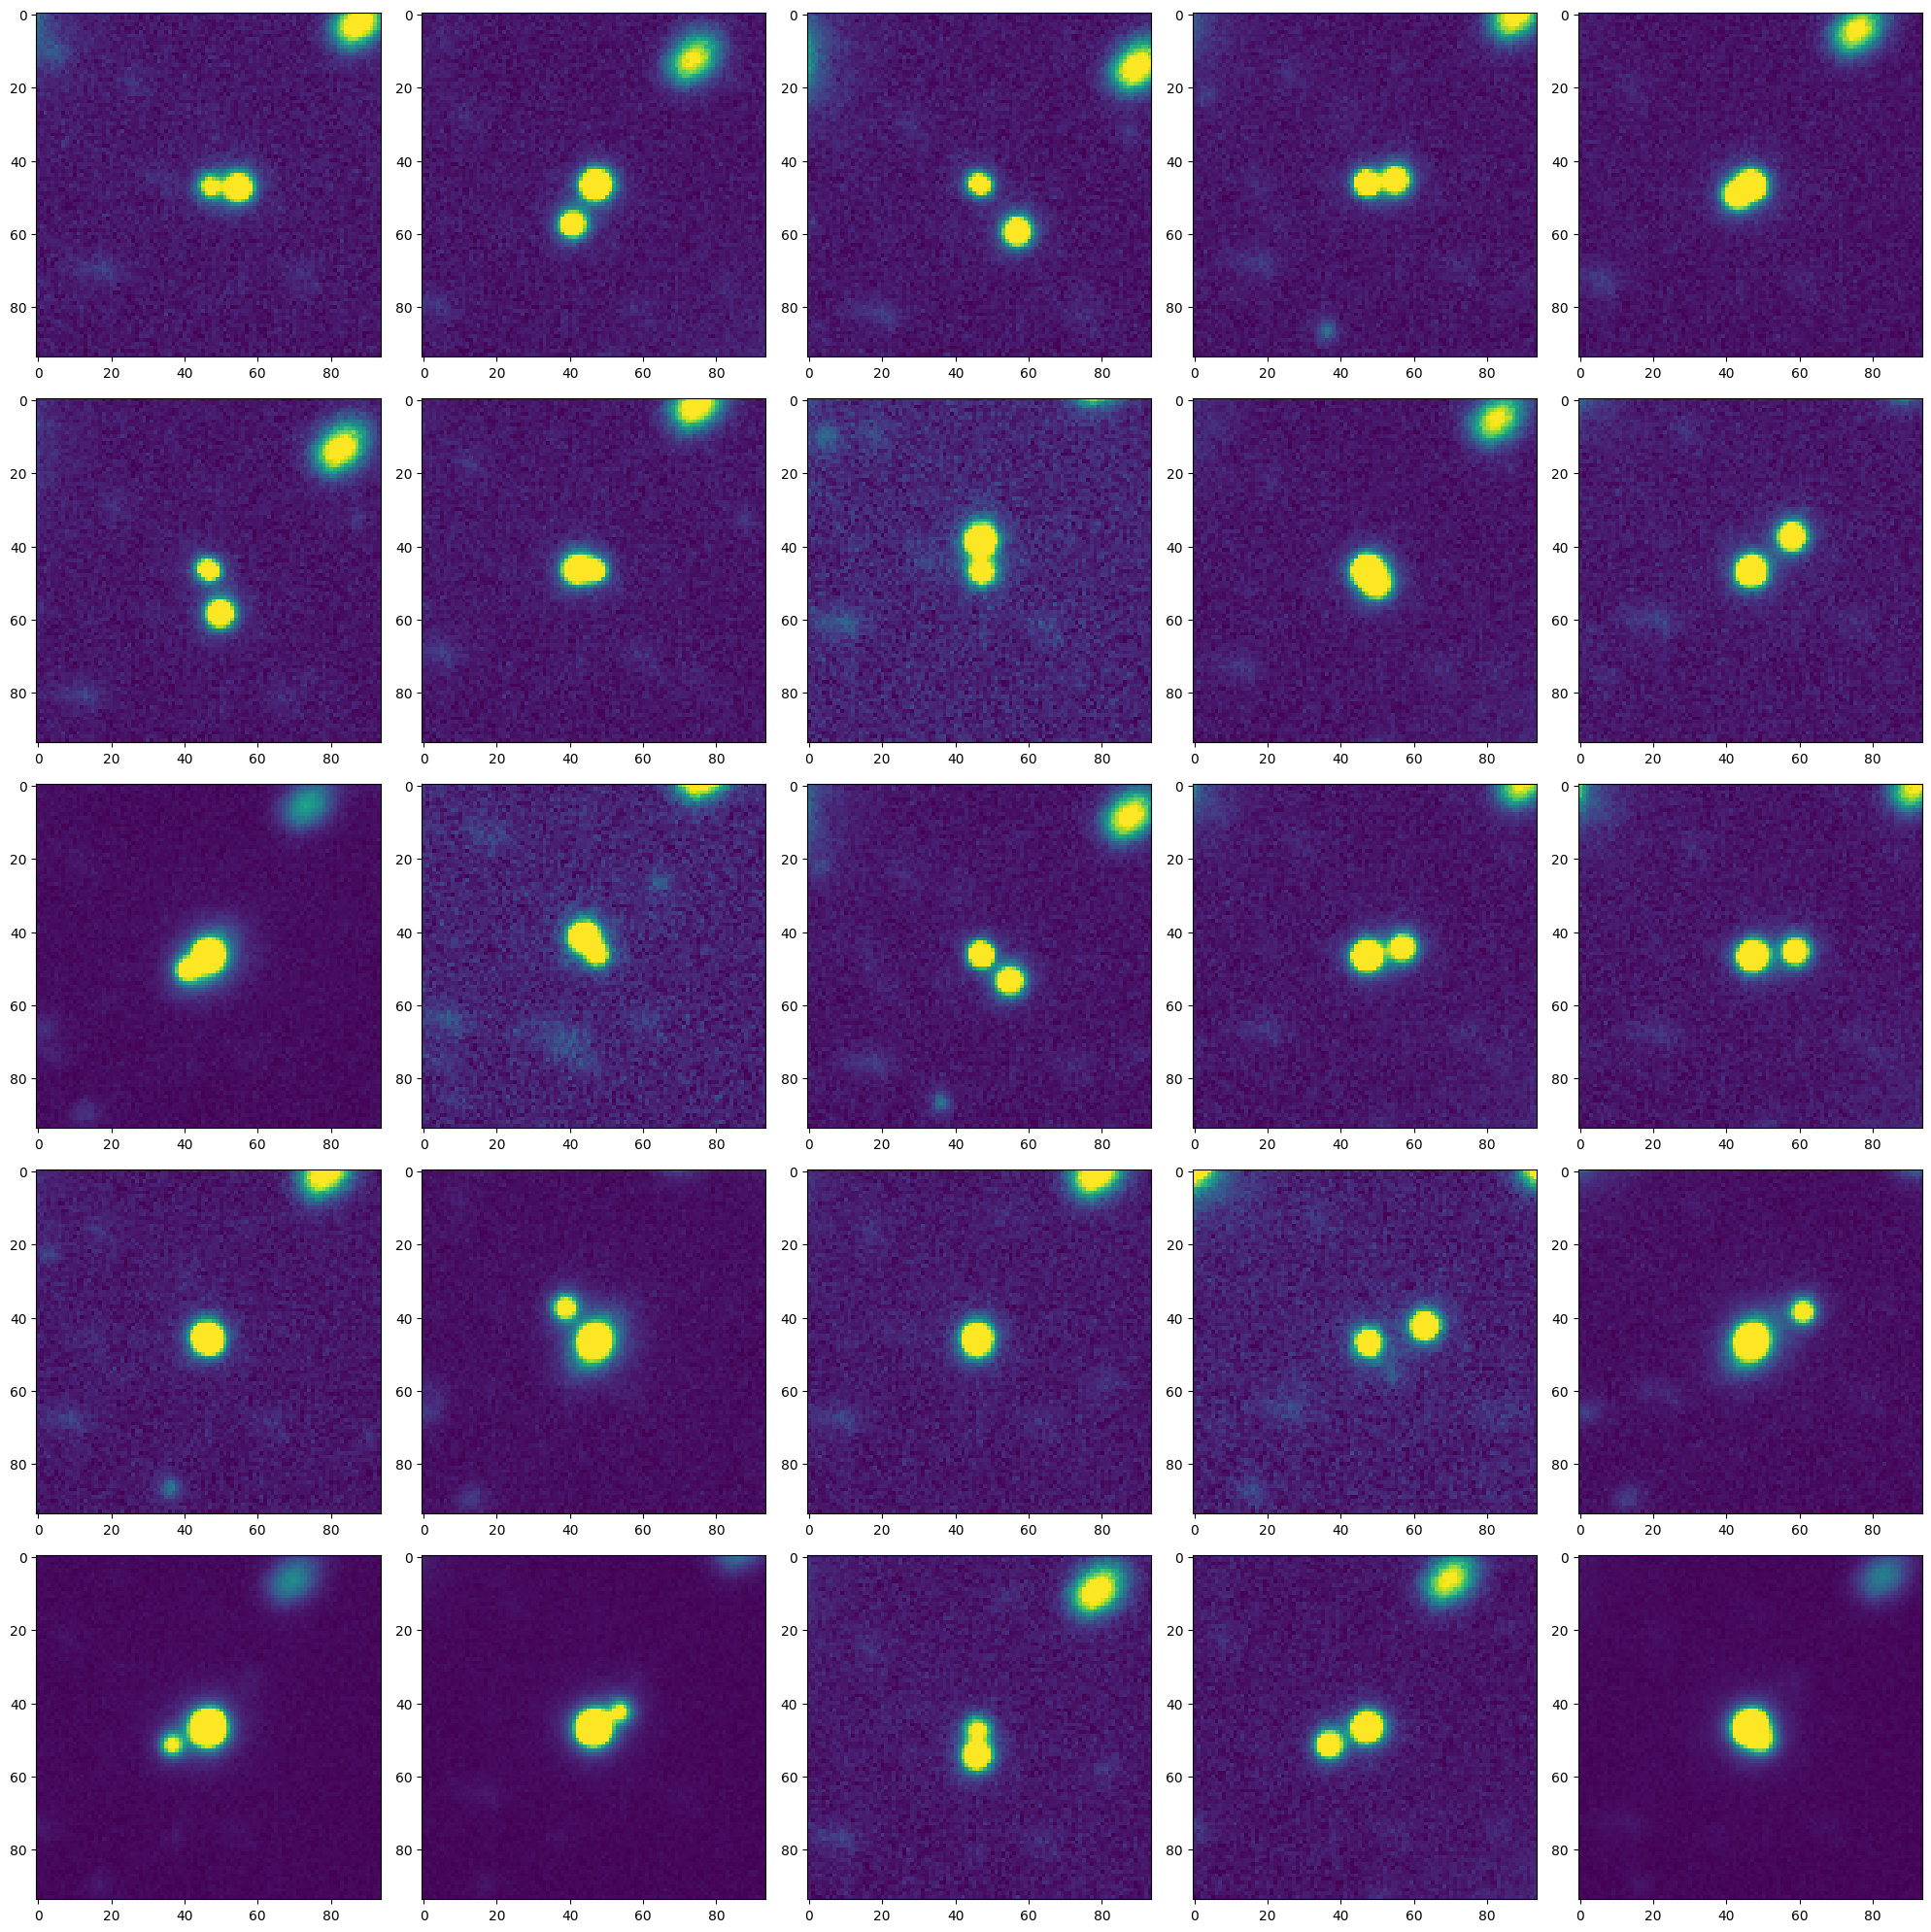

In [16]:
dual_training_images = []
for ii, image in tqdm(enumerate(glob.glob("data_preprocessing/training_datasets/dual_AGN_datasets/train_data/*.fits"))):
    with fits.open(image, memmap = False) as hdul:
        img = hdul[0].data
        if np.shape(img) != (94, 94):
            print(f"ERROR: image has shape {np.shape(img)}")
        dual_training_images.append(img)
        #print(f" {ii} images were successfully loaded, {image} is corrupted/could not be loaded")
    #except OSError:
random_dual_selection = np.random.choice(len(dual_training_images), size = 25)
fig, axes = plt.subplots(5, 5, figsize = (20,20))
counter = 0
for row in range(5):
    for col in range(5):
        img = dual_training_images[random_dual_selection[counter]]
        axes[row][col].imshow(img, vmin = np.percentile(img, 1), vmax = np.percentile(img, 99))
        counter += 1
plt.tight_layout()
plt.show()